# Compare sorters with some dataset generated with MEArec

Alessio Paolo Buccino author of [MEArec](https://github.com/alejoe91/MEArec) have generated some dataset

Here a comparison on the file **recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13_31.h5**


In [50]:
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spiketoolkit as st
import spikeextractors as se
from spiketoolkit.comparison import (setup_comparison_study, run_study_sorters,
            aggregate_sorting_comparison, aggregate_performances_table)

import MEAutility as mu
import MEArec as mr

%matplotlib notebook

In [17]:
# p = '/media/samuel/SamCNRS/DataSpikeSorting/mearec/'
# p = '/home/samuel/DataSpikeSorting/mearec/'
p = '/media/samuel/dataspikesorting/DataSpikeSortingHD2/mearec/'

study_folder = p + 'study_mearec'

mearec_filename = p + 'recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13_31.h5'

In [25]:
rec0  = se.MEArecRecordingExtractor(mearec_filename, locs_2d=False)
gt_sorting0 = se.MEArecSortingExtractor(mearec_filename)

# Inspect the dataset


The signal are simulated using [MEArec](https://github.com/alejoe91/MEArec) written by Alessio Buccino.

 * It is a **very dense** probe using the shape **SqMEA-10-15**.
 * The probe have 10 X 10 channels.
 * There are **50** templates = **50** ground truth units.
 * As the array is dense, template have a high spatial definition and redundency.


### Probe

<IPython.core.display.Javascript object>


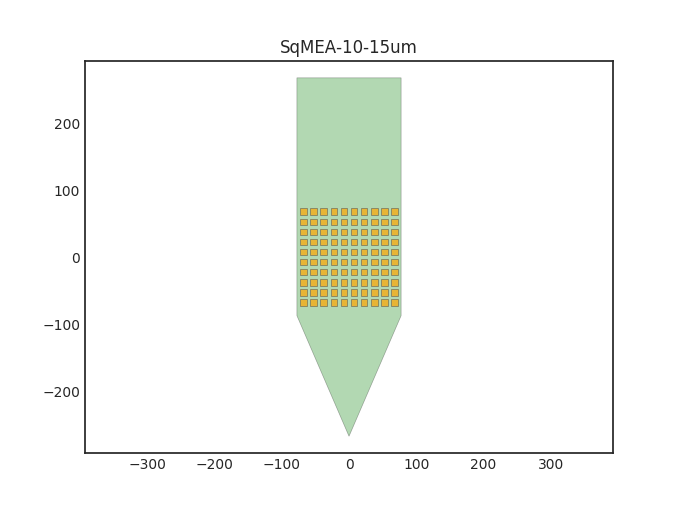

Text(0.5,1,'SqMEA-10-15um')

In [21]:
recgen = mr.load_recordings(mearec_filename)

probe_info = recgen.info['electrodes']
probe_name = recgen.info['electrodes']['electrode_name']
mea = mu.return_mea(info=probe_info)
fig, ax = plt.subplots()
mu.plot_probe(mea, ax=ax)
ax.set_title(probe_name)

### Some ground truth templates

### Compute template SNR

In [37]:
snr = st.validation.compute_unit_SNR(rec0, gt_sorting0)
snr = pd.Series(snr, index=gt_sorting0.get_unit_ids())
pd.DataFrame(snr).to_excel(p + 'units_snr.xlsx')

<IPython.core.display.Javascript object>


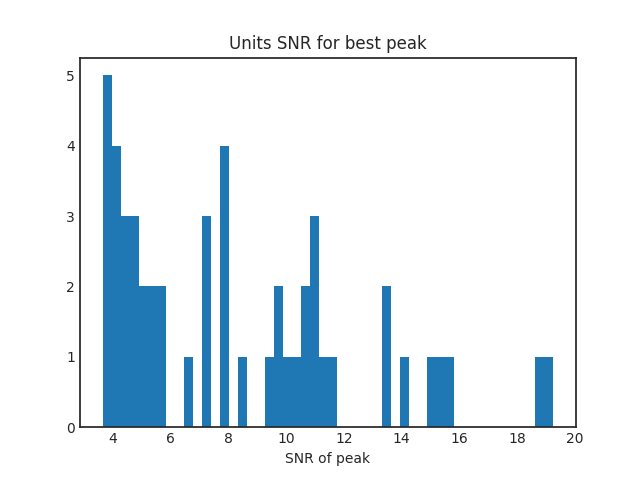

Text(0.5,0,'SNR of peak')

In [35]:
fig, ax = plt.subplots()
ax.hist(snr, bins=50)
ax.set_title('Units SNR for best peak')
ax.set_xlabel('SNR of peak')

## Step 1 : setup study folder

The file have been downloaded in the current directory.

Note: this file have a 3D geometry for teh probe. Many sorters work only with 2D.
So here we remove the first dimenssion of "location" in the recording.


In [ ]:


for chan in rec0.get_channel_ids():
    loc = rec0.get_channel_property(chan, 'location')
    rec0.set_channel_property(chan, 'location', loc[1:])

gt_dict = {'rec0' : (rec0, gt_sorting0) }

setup_comparison_study(study_folder, gt_dict)


## Step 2 : run all sorter

This run all sorter on all recording and store the results in a working folder.

In [5]:
# sorter_list = ['tridesclous', 'herdingspikes','klusta', 'mountainsort4', 'spykingcircus']
# 'kilosort', 'kilosort2', 'ironclust' are not tested because I don't have matlab

sorter_list = ['tridesclous', 'herdingspikes', 'mountainsort4']
run_study_sorters(study_folder, sorter_list, mode='keep', engine='loop')

## Step3 : collect comparisons

This collect all results for all **(rec_name, sorter_name)** pair and apply the SortingComparison class for each.

This also concatenate performances in several dataframes.

In [40]:
comparisons = aggregate_sorting_comparison(study_folder, exhaustive_gt=True)

## plot confusion matrix

rec0 klusta
rec0 kilosort
rec0 herdingspikes
rec0 kilosort2
rec0 spykingcircus
rec0 tridesclous


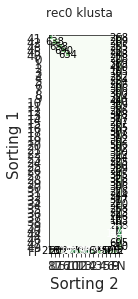

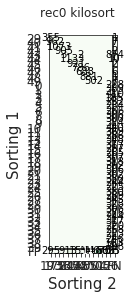

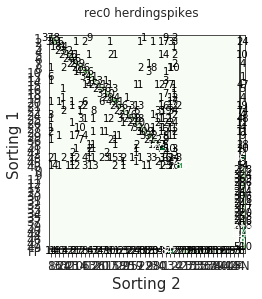

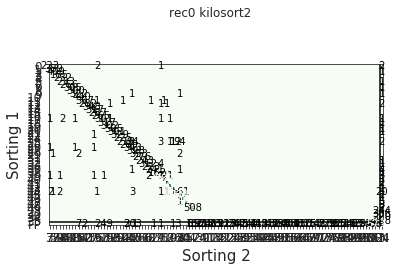

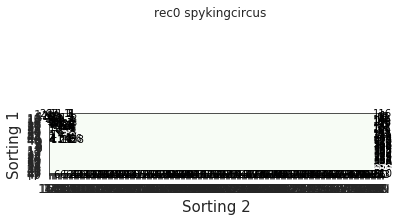

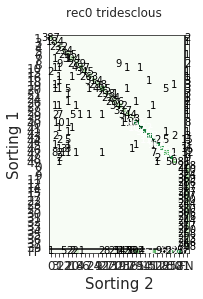

In [10]:
for (rec_name, sorter_name), comp in comparisons.items():
    print(rec_name, sorter_name)
    fig, ax = plt.subplots()
    comp.plot_confusion_matrix(ax=ax)
    fig.suptitle(rec_name + ' ' + sorter_name)

## print summary and average perf

In [8]:
for (rec_name, sorter_name), comp in comparisons.items():
    print(rec_name, sorter_name)
    comp.print_summary()
    comp.print_performance('pooled_with_average')

rec0 klusta
SUMMARY
GT num_units: 50
TESTED num_units: 16
num_well_detected: 0 
num_bad: 11
num_false_positive_units 0

PERFORMANCE
Method : pooled_with_average

ACCURACY: 6.760951649045929
RECALL: 7.281469993980179
PRECISION: 90.9023707826402
FALSE DISCOVERY RATE: 9.097629217359776
MISS RATE: 92.71853000601982
MISS CLASSIFICATION RATE: 0.0

rec0 kilosort
SUMMARY
GT num_units: 50
TESTED num_units: 15
num_well_detected: 7 
num_bad: 4
num_false_positive_units 0

PERFORMANCE
Method : pooled_with_average

ACCURACY: 17.937860367153935
RECALL: 19.906628935907463
PRECISION: 81.85324699921523
FALSE DISCOVERY RATE: 18.146753000784763
MISS RATE: 80.00784471928556
MISS CLASSIFICATION RATE: 0.09429376178878782

rec0 herdingspikes
SUMMARY
GT num_units: 50
TESTED num_units: 45
num_well_detected: 12 
num_bad: 14
num_false_positive_units 0

PERFORMANCE
Method : pooled_with_average

ACCURACY: 53.666574808381675
RECALL: 57.60635093865014
PRECISION: 89.70084971300633
FALSE DISCOVERY RATE: 10.299150286993

## Step 4 : collect tables

**dataframes** is a dict that contain several results formated in dataframes:
  * run_times : time for computing each one
  * perf_pooled_with_sum: performance with method **pooled_with_sum**
  * perf_pooled_with_average: performance with method **pooled_with_average**
  * nb_units_above_threshold: count how many units detect with a treshold on a perf columns.

In [42]:
dataframes = aggregate_performances_table(study_folder, exhaustive_gt=True)

    gt_unit_id  accuracy    recall  precision  false_discovery_rate  \
0            0  0.000000  0.000000        NaN                   NaN   
1            1  0.989744  0.992288   0.997416              0.002584   
2            2  0.000000  0.000000        NaN                   NaN   
3            3  0.978378  0.978378   1.000000              0.000000   
4            4  1.000000  1.000000   1.000000              0.000000   
5            5  0.970339  0.982833   0.987069              0.012931   
6            6  0.973684  0.973684   1.000000              0.000000   
7            7  0.990033  0.990033   1.000000              0.000000   
8            8  0.591667  0.969283   0.602972              0.397028   
9            9  0.000000  0.000000        NaN                   NaN   
10          10  0.993151  0.993151   1.000000              0.000000   
11          11  0.000000  0.000000        NaN                   NaN   
12          12  0.000000  0.000000        NaN                   NaN   
13    

    gt_unit_id  accuracy    recall  precision  false_discovery_rate  \
0            0  0.000000  0.000000        NaN                   NaN   
1            1  0.697128  0.697128   1.000000              0.000000   
2            2  0.000000  0.000000        NaN                   NaN   
3            3  0.000000  0.000000        NaN                   NaN   
4            4  0.995690  0.995690   1.000000              0.000000   
5            5  0.711207  0.711207   1.000000              0.000000   
6            6  0.000000  0.000000        NaN                   NaN   
7            7  0.000000  0.000000        NaN                   NaN   
8            8  0.000000  0.000000        NaN                   NaN   
9            9  0.000000  0.000000        NaN                   NaN   
10          10  0.958904  0.958904   1.000000              0.000000   
11          11  0.000000  0.000000        NaN                   NaN   
12          12  0.000000  0.000000        NaN                   NaN   
13    

In [12]:
dataframes['perf_pooled_with_sum']

accuracy    recall precision false_discovery_rate  \
rec_name sorter_name                                                        
rec0     herdingspikes  0.506712  0.544028  0.880774             0.119226   
         klusta         0.161992  0.165291  0.890304             0.109696   
         tridesclous    0.627984  0.712458  0.841181             0.158819   
         kilosort       0.366699  0.396828   0.82847              0.17153   
         kilosort2      0.922512  0.947002  0.972731            0.0272686   
         spykingcircus   0.33921  0.340132  0.992068           0.00793201   

                        miss_rate misclassification_rate  
rec_name sorter_name                                      
rec0     herdingspikes   0.447324              0.0189663  
         klusta          0.834709                      0  
         tridesclous     0.286376             0.00405386  
         kilosort         0.60195             0.00202693  
         kilosort2      0.0526036             0.00743207  
         spykingcircus    0.65576             0.00622557

In [13]:
dataframes['perf_pooled_with_average']

accuracy     recall precision false_discovery_rate  \
rec_name sorter_name                                                          
rec0     herdingspikes   0.536666   0.576064  0.897008             0.102992   
         klusta         0.0676095  0.0728147  0.909024            0.0909763   
         tridesclous     0.533828   0.596157  0.894773             0.105227   
         kilosort        0.179379   0.199066  0.818532             0.181468   
         kilosort2       0.897439   0.917387  0.978227            0.0217732   
         spykingcircus   0.314492   0.315895  0.991791           0.00820865   

                        miss_rate misclassification_rate  
rec_name sorter_name                                      
rec0     herdingspikes    0.42142              0.0198142  
         klusta          0.927185                      0  
         tridesclous     0.403811             0.00335219  
         kilosort        0.800078            0.000942938  
         kilosort2      0.0825369             0.00895285  
         spykingcircus   0.682318             0.00540255

In [14]:
dataframes['count_units']

num_gt  num_sorter  num_well_detected  num_redundant  \
rec_name sorter_name                                                           
rec0     herdingspikes      50          45                 12              6   
         klusta             50          16                  0              6   
         tridesclous        50          32                 18              1   
         kilosort           50          15                  7              3   
         kilosort2          50         105                 43              3   
         spykingcircus      50         274                  2             20   

                        num_false_positive  num_bad  
rec_name sorter_name                                 
rec0     herdingspikes                   0       14  
         klusta                          0       11  
         tridesclous                     0        2  
         kilosort                        0        4  
         kilosort2                       2       59  
         spykingcircus                  62      252

## Step 5: inspect result by spiketrain

For finer exploration, we can also compute for all **(rec_name, sorter_name)** pair the performance with method=**by_spiketrain**.

This give a give result for each units of the ground truth.

In [13]:
for (rec_name, sorter_name), comp in comparisons.items():
    print(rec_name, sorter_name)
    perf = comp.get_performance(method='raw_count')
    display(perf)

rec0 herdingspikes


,tp,fn,cl,fp,num_gt,num_tested,tested_id
0,0,228,0,0,228,0,-1
1,378,0,11,14,389,404,8
2,366,24,20,18,410,388,16
3,184,0,1,40,185,227,30
4,232,0,0,3,232,237,24
5,216,10,8,42,234,258,32
6,266,0,0,8,266,274,23
7,299,4,3,27,306,335,10
8,286,0,14,12,300,317,14
9,0,324,0,0,324,0,-1


rec0 kilosort


,tp,fn,cl,fp,num_gt,num_tested,tested_id
0,0,228,0,0,228,0,-1
1,0,389,0,0,389,0,-1
2,0,410,0,0,410,0,-1
3,0,185,0,0,185,0,-1
4,0,232,0,0,232,0,-1
5,0,234,0,0,234,0,-1
6,0,266,0,0,266,0,-1
7,0,306,0,0,306,0,-1
8,0,300,0,0,300,0,-1
9,0,324,0,0,324,0,-1


rec0 kilosort2


,tp,fn,cl,fp,num_gt,num_tested,tested_id
0,223,2,3,0,228,223,7
1,389,0,0,0,389,389,38
2,409,1,0,0,410,409,58
3,185,0,0,0,185,185,78
4,232,0,0,0,232,232,94
5,233,1,0,0,234,233,40
6,266,0,0,0,266,266,60
7,305,1,0,0,306,305,80
8,300,0,0,0,300,300,75
9,322,1,1,7,324,331,86


rec0 spykingcircus


,tp,fn,cl,fp,num_gt,num_tested,tested_id
0,0,228,0,0,228,0,-1
1,267,116,6,0,389,267,146
2,0,410,0,0,410,0,-1
3,0,185,0,0,185,0,-1
4,231,1,0,0,232,231,167
5,165,67,2,0,234,165,14
6,0,266,0,0,266,0,-1
7,0,306,0,0,306,0,-1
8,0,300,0,0,300,0,-1
9,0,324,0,0,324,0,-1


rec0 tridesclous


,tp,fn,cl,fp,num_gt,num_tested,tested_id
0,0,228,0,0,228,0,-1
1,386,3,0,1,389,387,0
2,0,410,0,0,410,0,-1
3,181,4,0,0,185,186,3
4,232,0,0,0,232,232,1
5,229,4,1,3,234,234,22
6,259,7,0,0,266,259,2
7,298,3,5,0,306,303,10
8,284,9,7,187,300,474,18
9,0,324,0,0,324,0,-1


In [15]:
for (rec_name, sorter_name), comp in comparisons.items():
    print(rec_name, sorter_name)
    perf = comp.get_performance(method='by_spiketrain')
    display(perf)

rec0 klusta


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
0,0.000000,0.000000,NaN,NaN,1.000000,0.0
1,0.000000,0.000000,NaN,NaN,1.000000,0.0
2,0.000000,0.000000,NaN,NaN,1.000000,0.0
3,0.000000,0.000000,NaN,NaN,1.000000,0.0
4,0.000000,0.000000,NaN,NaN,1.000000,0.0
5,0.000000,0.000000,NaN,NaN,1.000000,0.0
6,0.000000,0.000000,NaN,NaN,1.000000,0.0
7,0.000000,0.000000,NaN,NaN,1.000000,0.0
8,0.000000,0.000000,NaN,NaN,1.000000,0.0
9,0.000000,0.000000,NaN,NaN,1.000000,0.0


rec0 kilosort


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
0,0.000000,0.000000,NaN,NaN,1.000000,0.000000
1,0.000000,0.000000,NaN,NaN,1.000000,0.000000
2,0.000000,0.000000,NaN,NaN,1.000000,0.000000
3,0.000000,0.000000,NaN,NaN,1.000000,0.000000
4,0.000000,0.000000,NaN,NaN,1.000000,0.000000
5,0.000000,0.000000,NaN,NaN,1.000000,0.000000
6,0.000000,0.000000,NaN,NaN,1.000000,0.000000
7,0.000000,0.000000,NaN,NaN,1.000000,0.000000
8,0.000000,0.000000,NaN,NaN,1.000000,0.000000
9,0.000000,0.000000,NaN,NaN,1.000000,0.000000


rec0 herdingspikes


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
0,0.000000,0.000000,NaN,NaN,1.000000,0.000000
1,0.964286,1.000000,0.964286,0.035714,0.000000,0.028278
2,0.897059,0.938462,0.953125,0.046875,0.058537,0.048780
3,0.821429,1.000000,0.821429,0.178571,0.000000,0.005405
4,0.987234,1.000000,0.987234,0.012766,0.000000,0.000000
5,0.805970,0.955752,0.837209,0.162791,0.042735,0.034188
6,0.970803,1.000000,0.970803,0.029197,0.000000,0.000000
7,0.906061,0.986799,0.917178,0.082822,0.013072,0.009804
8,0.959732,1.000000,0.959732,0.040268,0.000000,0.046667
9,0.000000,0.000000,NaN,NaN,1.000000,0.000000


rec0 kilosort2


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
0,0.991111,0.991111,1.000000,0.000000,0.008772,0.013158
1,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
2,0.997561,0.997561,1.000000,0.000000,0.002439,0.000000
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
4,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
5,0.995726,0.995726,1.000000,0.000000,0.004274,0.000000
6,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
7,0.996732,0.996732,1.000000,0.000000,0.003268,0.000000
8,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
9,0.975758,0.996904,0.978723,0.021277,0.003086,0.003086


rec0 spykingcircus


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
0,0.000000,0.000000,NaN,NaN,1.000000,0.000000
1,0.697128,0.697128,1.000000,0.000000,0.298201,0.015424
2,0.000000,0.000000,NaN,NaN,1.000000,0.000000
3,0.000000,0.000000,NaN,NaN,1.000000,0.000000
4,0.995690,0.995690,1.000000,0.000000,0.004310,0.000000
5,0.711207,0.711207,1.000000,0.000000,0.286325,0.008547
6,0.000000,0.000000,NaN,NaN,1.000000,0.000000
7,0.000000,0.000000,NaN,NaN,1.000000,0.000000
8,0.000000,0.000000,NaN,NaN,1.000000,0.000000
9,0.000000,0.000000,NaN,NaN,1.000000,0.000000


rec0 tridesclous


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
0,0.000000,0.000000,NaN,NaN,1.000000,0.000000
1,0.992308,0.994859,0.997423,0.002577,0.005141,0.000000
2,0.000000,0.000000,NaN,NaN,1.000000,0.000000
3,0.994595,0.994595,1.000000,0.000000,0.005405,0.000000
4,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
5,0.979079,1.000000,0.979079,0.020921,0.000000,0.000000
6,0.996241,0.996241,1.000000,0.000000,0.003759,0.000000
7,0.993464,1.000000,0.993464,0.006536,0.000000,0.006536
8,0.564453,0.993127,0.566667,0.433333,0.006667,0.030000
9,0.000000,0.000000,NaN,NaN,1.000000,0.000000


## Step 6 : easy plot with seaborn

With the seaborn package, it is very easy to summary with plot dataframes.

Here some basic example for performances and run times.

### Run times

In [ ]:
run_times = dataframes['run_times'].reset_index()
fig, ax = plt.subplots()
sns.barplot(data=run_times, x='rec_name', y='run_time', hue='sorter_name', ax=ax)
ax.set_title('Run times (s)')

### By spiketrain

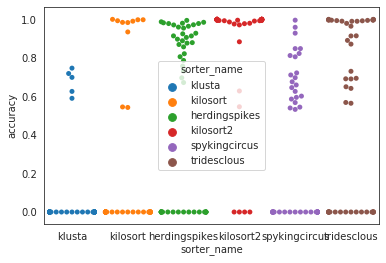

In [21]:
perfs = dataframes['perf_by_spiketrain'].reset_index()
fig, ax = plt.subplots()
sns.swarmplot(data=perfs, x='sorter_name', y='accuracy', hue='sorter_name', ax=ax)

### Accuracy sum

(0, 1)

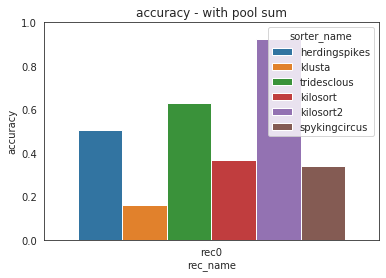

In [22]:
perfs = dataframes['perf_pooled_with_sum'].reset_index()
fig, ax = plt.subplots()
sns.barplot(data=perfs, x='rec_name', y='accuracy', hue='sorter_name', ax=ax)
ax.set_title('accuracy - with pool sum')
ax.set_ylim(0, 1)

### Accuracy average

(0, 1)

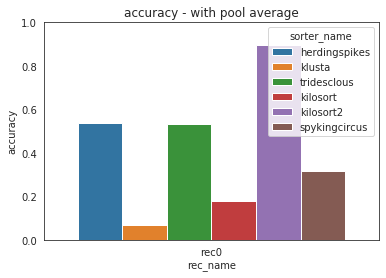

In [23]:
perfs = dataframes['perf_pooled_with_average'].reset_index()
fig, ax = plt.subplots()
sns.barplot(data=perfs, x='rec_name', y='accuracy', hue='sorter_name', ax=ax)
ax.set_title('accuracy - with pool average')
ax.set_ylim(0, 1)

### accuracy vs SNR

<IPython.core.display.Javascript object>


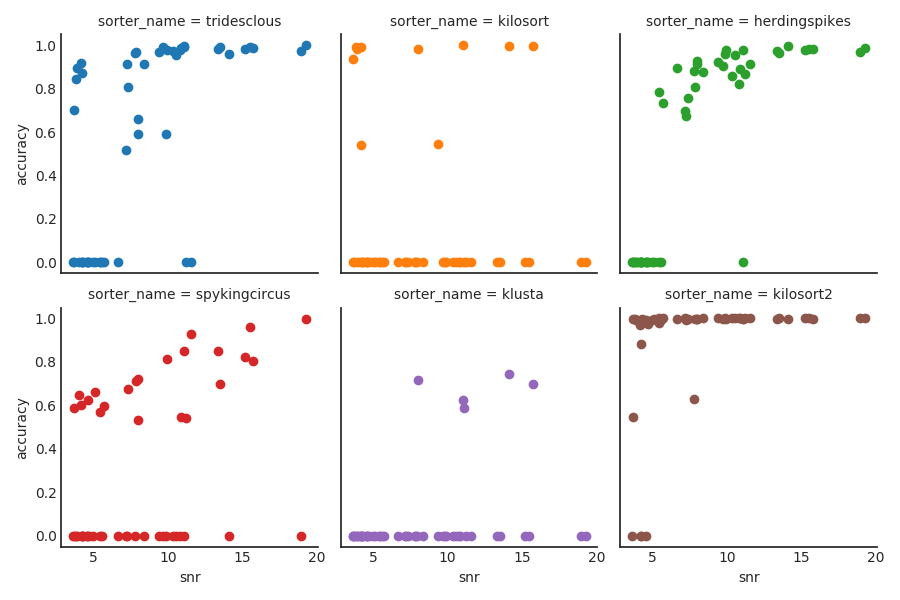

In [54]:
# insert snr columns
perfs = dataframes['perf_by_spiketrain'].reset_index()
perfs['snr'] = perfs['gt_unit_id'].apply(lambda id: snr.loc[id])

grid = sns.FacetGrid(perfs, hue='sorter_name', col='sorter_name', col_wrap=3)
grid.map(plt.plot, 'snr', 'accuracy', marker="o", ls='None')




### How many units detected above threshold

The max is 50 cells.

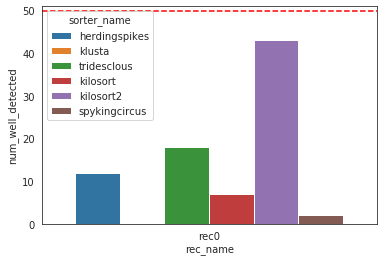

In [24]:
perfs = dataframes['count_units'].reset_index()

fig, ax = plt.subplots()
ax = sns.barplot(data=perfs, x='rec_name', y='num_well_detected', hue='sorter_name', ax=ax)
ax.set_ylim(0, 51)
ax.axhline(50, ls='--', color='red')

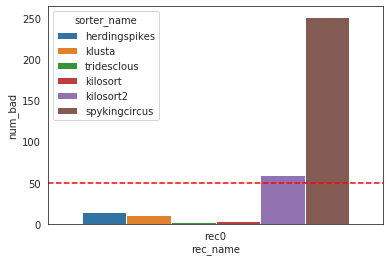

In [25]:
perfs = dataframes['count_units'].reset_index()

fig, ax = plt.subplots()
ax = sns.barplot(data=perfs, x='rec_name', y='num_bad', hue='sorter_name', ax=ax)
ax.axhline(50, ls='--', color='red')

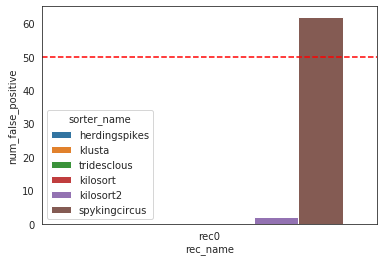

In [26]:
perfs = dataframes['count_units'].reset_index()

fig, ax = plt.subplots()
ax = sns.barplot(data=perfs, x='rec_name', y='num_false_positive', hue='sorter_name', ax=ax)
ax.axhline(50, ls='--', color='red')

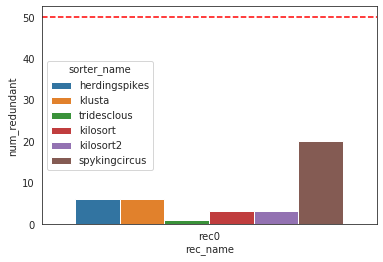

In [27]:
perfs = dataframes['count_units'].reset_index()

fig, ax = plt.subplots()
ax = sns.barplot(data=perfs, x='rec_name', y='num_redundant', hue='sorter_name', ax=ax)
ax.axhline(50, ls='--', color='red')